In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from itertools import chain
import pickle
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,QuantileTransformer
from sklearn.compose import TransformedTargetRegressor

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Load Data

In [2]:
# # Read in average monthly consumption dataframe
X = pd.read_csv('AMC_dataframe.csv', index_col=['ProfileID'])
AMC_df = X.copy()
X.reset_index(inplace = True)

# # Extract household IDs
sorted_households_ids = pd.read_pickle('sorted_households_winter_weekdays.pkl') # Read pickle file with household ids that pass Error Threshold
household_ids = list(sorted_households_ids.values())
householdIDs =  [l.tolist() for l in household_ids]
householdIDs = list(map(int, chain.from_iterable(householdIDs)))

# # Filter the sorted households ids in AMC dataframe
AMC_df = X[X['ProfileID'].isin(householdIDs)] 
AMC_df.set_index(['ProfileID'], inplace=True)


# Load Gauss Fit Features for the winter and weekday features
df_50_150 = pd.read_csv(r'data/features/FitFeatures/Winter_Weekdays/Winter_weekdays_FitFeatures_50_150.csv',  header=[0, 1], index_col = 0)
df_150_400 = pd.read_csv(r'data/features/FitFeatures/Winter_Weekdays/Winter_weekdays_FitFeatures_150_400.csv',  header=[0, 1], index_col = 0)
df_400_600 = pd.read_csv(r'data/features/FitFeatures/Winter_Weekdays/Winter_weekdays_FitFeatures_400_600.csv',  header=[0, 1], index_col = 0)
df_600_1200 = pd.read_csv('data/features/FitFeatures/Winter_Weekdays/Winter_weekdays_FitFeatures_600_1200.csv',  header=[0, 1], index_col = 0)
df_1200_2500 = pd.read_csv(r'data/features/FitFeatures/Winter_Weekdays/Winter_weekdays_FitFeatures_1200_2500.csv',  header=[0, 1], index_col = 0)
df_2500_4000 = pd.read_csv(r'data/features/FitFeatures/Winter_Weekdays/Winter_weekdays_FitFeatures_2500_4000.csv',  header=[0, 1], index_col = 0)

# Create the Gauss Fit Features Dataframe
frame = [df_150_400,df_400_600,df_600_1200,df_1200_2500,df_2500_4000]#df_150_400,df_2500_4000
df = pd.DataFrame()
df = df_50_150.append(frame)

#Select rows based on condition 
df.reset_index(inplace=True)

# Create dataframe with the winter weekday gauss fit features
df_winter_weekdays = df[df['ProfileID'].isin(AMC_df.index.values)].copy()
df_winter_weekdays.set_index(['ProfileID'], inplace=True)
df_winter_weekdays = df_winter_weekdays.droplevel([0],axis = 1) # Drop level on multi column

# # Filter out all household ids from AMC dataframe that are not in Gauss Fit Features Dataframe 
AMC_df.reset_index(['ProfileID'], inplace=True)
AMC_df = X[X['ProfileID'].isin(df_winter_weekdays.index.values)] #df_winter_weekdays.index.values
AMC_df.set_index(['ProfileID'], inplace=True)

# Load Metadata
df1 = pd.read_csv(r"data/survey_data/delskv-1994-2014.csv",  header=[0], index_col = 0)
meta_df = df1[['floor_area', 'wall_material','total_adults', 'total_children','monthly_income','water_access','roof_material','years_electrified']] # Select relevant features
meta_df['total_residents'] = meta_df.loc[:,'total_adults'] + meta_df.loc[:,'total_children'] # Create total_residents feature


# Drop all NaN values from dataframe
meta_df = meta_df.dropna()

# Filter out only households with Gauss Fit that completed a survey
households_ids1 = AMC_df.index.to_list()
meta_df_filtered = meta_df.loc[meta_df.index.isin(households_ids1),:]

# # Filter out only households that completed a survey from Gauss Fit
households_ids2 = meta_df_filtered.index.to_list()
AMC_df_filtered = AMC_df.loc[AMC_df.index.isin(households_ids2),:]

C:\Users\MEDIA_~1\AppData\Local\Temp/ipykernel_11376/552975373.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_df['total_residents'] = meta_df.loc[:,'total_adults'] + meta_df.loc[:,'total_children'] # Create total_residents feature


# Encode categorical data

In [3]:
enc = LabelEncoder()

# Encode the non-numeric columns from the Meta Data
enc.fit(meta_df_filtered['roof_material'])
meta_df_filtered.loc[:,'roof_material_ENC'] = enc.transform(meta_df_filtered.loc[:,'roof_material'])

enc.fit(meta_df_filtered['water_access'])
meta_df_filtered.loc[:,'water_access_ENC'] = enc.transform(meta_df_filtered.loc[:,'water_access'])

enc.fit(meta_df_filtered['wall_material'])
meta_df_filtered.loc[:,'wall_material_ENC'] = enc.transform(meta_df_filtered.loc[:,'wall_material'])

meta_df_encoded = meta_df_filtered.loc[:,['floor_area', 'monthly_income','total_residents','roof_material_ENC','water_access_ENC','wall_material_ENC', 'years_electrified']].copy()
encoded_df = pd.merge(meta_df_encoded,AMC_df, left_index = True,right_index=True)

C:\Users\MEDIA_LAB\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


# Combine dataframes

In [11]:
ids_winters_months = pd.read_pickle(r'winter_months_ids') # Uncomment when using only winter weekdays data

encoded_df2 = pd.merge(encoded_df, df_winter_weekdays, left_index = True, right_index = True) # df_winter_weekdays

encoded_df_filtered = encoded_df2.loc[encoded_df2.index.isin(ids_winters_months),:] # Uncomment when using winter weekdays dataframe

# Filter out Businesses

In [12]:
encoded_df_filtered

,floor_area,monthly_income,total_residents,roof_material_ENC,water_access_ENC,wall_material_ENC,years_electrified,AMC_winter,AMC_yearly,sigma1,sigma2,mu1,A1,sigma3,sigma4,mu2,A2
ProfileID,,,,,,,,,,,,,,,,,
121,50.0,23396.23,7,0,3,2,10.0,157.842976,368.275604,0.606061,2.105263,6,2.592778,3.529412,2.608696,18,5.002870
122,50.0,6981.13,4,0,3,2,10.0,361.899844,651.857427,1.935484,5.000000,8,10.081389,1.818182,1.754386,19,9.779074
123,50.0,12452.83,8,0,3,2,10.0,226.768590,571.824360,1.224490,0.727273,7,3.063241,1.025641,2.857143,17,7.762037
124,50.0,15094.34,10,0,3,2,10.0,242.603886,658.141400,2.222222,3.636364,10,5.262037,1.052632,2.608696,18,7.226204
125,50.0,7924.53,7,0,3,2,10.0,327.069246,803.409776,0.675676,2.000000,6,7.868056,3.157895,2.222222,19,8.029074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12028980,57.0,11772.73,5,0,3,6,26.0,865.223966,845.719008,0.813008,1.132075,6,7.095536,3.703704,2.040816,19,8.574940
12029010,59.0,227.27,1,4,2,6,30.0,396.253795,415.556173,2.033898,3.076923,8,2.705357,1.666667,2.222222,18,4.939881
12029019,132.0,1022.73,2,4,3,6,30.0,412.007433,448.671829,0.526316,1.621622,6,3.422917,1.904762,2.564103,19,3.453750


In [13]:
business_ids = pd.read_pickle('business_ids.pkl') # Read pickle file

encoded_df_filtered = encoded_df_filtered.loc[~encoded_df_filtered.index.isin(business_ids),:]

In [14]:
encoded_df_filtered

,floor_area,monthly_income,total_residents,roof_material_ENC,water_access_ENC,wall_material_ENC,years_electrified,AMC_winter,AMC_yearly,sigma1,sigma2,mu1,A1,sigma3,sigma4,mu2,A2
ProfileID,,,,,,,,,,,,,,,,,
121,50.0,23396.23,7,0,3,2,10.0,157.842976,368.275604,0.606061,2.105263,6,2.592778,3.529412,2.608696,18,5.002870
122,50.0,6981.13,4,0,3,2,10.0,361.899844,651.857427,1.935484,5.000000,8,10.081389,1.818182,1.754386,19,9.779074
123,50.0,12452.83,8,0,3,2,10.0,226.768590,571.824360,1.224490,0.727273,7,3.063241,1.025641,2.857143,17,7.762037
124,50.0,15094.34,10,0,3,2,10.0,242.603886,658.141400,2.222222,3.636364,10,5.262037,1.052632,2.608696,18,7.226204
125,50.0,7924.53,7,0,3,2,10.0,327.069246,803.409776,0.675676,2.000000,6,7.868056,3.157895,2.222222,19,8.029074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12028980,57.0,11772.73,5,0,3,6,26.0,865.223966,845.719008,0.813008,1.132075,6,7.095536,3.703704,2.040816,19,8.574940
12029010,59.0,227.27,1,4,2,6,30.0,396.253795,415.556173,2.033898,3.076923,8,2.705357,1.666667,2.222222,18,4.939881
12029019,132.0,1022.73,2,4,3,6,30.0,412.007433,448.671829,0.526316,1.621622,6,3.422917,1.904762,2.564103,19,3.453750


In [ ]:
# Save the combined dataframe
encoded_df_filtered.to_csv('WDF.csv')

# Convert data to log scale

In [7]:
def logScale(temp_df):

    temp_df['floor_area(log)'] = np.log(temp_df['floor_area'])
    temp_df['monthly_income(log)'] = np.log(temp_df['monthly_income'])
    temp_df['AMC_winter(log)'] = np.log(temp_df['AMC_winter'])
    temp_df['AMC_yearly(log)'] = np.log(temp_df['AMC_yearly'])
    temp_df['sigma1(log)'] = np.log(temp_df['sigma1'])
    temp_df['sigma2(log)'] = np.log(temp_df['sigma2'])
    temp_df['A1(log)'] = np.log(temp_df['A1'])
    temp_df['sigma3(log)'] = np.log(temp_df['sigma3'])
    temp_df['sigma4(log)'] = np.log(temp_df['sigma4'])
    temp_df['A2(log)'] = np.log(temp_df['A2'])

    # Drop all infinity values
    # Replace infinite updated data with nan
    temp_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    # Drop rows with NaN
    temp_df.dropna(inplace=True)

    return temp_df

df = logScale(encoded_df_filtered)

<ipython-input-7-373720921266>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['floor_area(log)'] = np.log(temp_df['floor_area'])
C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-7-373720921266>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['monthly_income(log)'] = np.log(temp_df['monthly_income'])
<ipython-input-7-3737

# Remove outliers

In [ ]:

# Remove the outliers from the dataset to try and improve results
####################################################################################################################################
def Remove_Outlier_Indices(df, target_feature):
    Q1 = df[target_feature].quantile(0.25)
    Q3 = df[target_feature].quantile(0.75)
    IQR = Q3 - Q1
    trueList = ~((df[target_feature] < (Q1 - 1.5 * IQR)) |(df[target_feature] > (Q3 + 1.5 * IQR)))
    return trueList


target_feature = ['sigma1','sigma2','sigma3','sigma4']

for feature in target_feature:
    # Index List of Non-Outliers
    nonOutlierList = Remove_Outlier_Indices(df,feature)

    # Non-Outlier Subset of the Given Dataset
    df = df[nonOutlierList]

# Take a copy
df_outliers_removed = df.copy()

# Perform Multiple Linear Regression

In [8]:
def merge(list1, list2):
      
    merged_list = []
    for i in range(max((len(list1), len(list2)))):
  
        while True:
            try:
                tup = (list1[i], list2[i])
            except IndexError:
                if len(list1) > len(list2):
                    list2.append('')
                    tup = (list1[i], list2[i])
                elif len(list1) < len(list2):
                    list1.append('')
                    tup = (list1[i], list2[i])
                continue
  
            merged_list.append(tup)
            break
    return merged_list

In [9]:
def basic_LR_DT(X_train, X_test, y_train, y_test):
        
        tests_list1 = ['Linear Regression']
        features_list = y_test.columns.to_list()

        tuples1 = merge(tests_list1*len(y_test.columns),features_list)

        tuples = tuples1
        index = pd.MultiIndex.from_tuples(tuples,names = ['Regression', 'Features'])
        results_df = pd.DataFrame(columns = ['R-squared', 'MAE', 'RMSE'], index = index)

        columns = y_test.columns.to_list()
        ypred = pd.DataFrame(index = y_test.index)
        # print(results_df)
        for column in columns:
                #Create a LinearRegression object
                lr= LinearRegression()
                #Fit X and y 
                lr.fit(X_train, y_train[column])
                ypred[column] = lr.predict(X_test)
                ypred = ypred.round(decimals = 3)
                y_test = y_test.round(decimals = 3)
                #Metrics to evaluate your model 
                results_LR = [r2_score(y_test[column], ypred[column]), mean_absolute_error(y_test[column], ypred[column]), np.sqrt(mean_squared_error(y_test[column], ypred[column]))]
                # print(column)
                results_df.loc['Linear Regression', column] = results_LR

        return results_df, ypred, y_test

### Basic MLR

In [10]:
# Based on the above plots, there seems to be no correlation between the categorical meta features and the gauss-fit features. Remove the categorical features
y = df[['A1', 'A2','sigma1', 'sigma2', 'sigma3','sigma4', 'mu1', 'mu2']]
X = df[['floor_area', 'monthly_income', 'total_residents', 'roof_material_ENC','water_access_ENC', 'wall_material_ENC', 'years_electrified','AMC_winter', 'AMC_yearly']] # 'roof_material_ENC','water_access_ENC', 'wall_material_ENC',

#Split data into test and train
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=42)

results, y_pred, y_actual = basic_LR_DT(X_train, X_test, y_train, y_test)
results

R-squared       MAE      RMSE
Regression        Features                              
Linear Regression A1        0.633086  1.495464  2.417178
                  A2         0.63848  1.357973  2.294669
                  sigma1    0.012683  0.617209  0.810515
                  sigma2    0.080151  0.685815  0.886955
                  sigma3    0.059884  0.591437  0.759864
                  sigma4    0.017782  0.509953  0.662015
                  mu1       0.048318  1.038411  1.367292
                  mu2       0.029977  0.904985  1.242359

# Calculate the MAPE and sMAPE

In [11]:
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def sMAPE(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

In [57]:
error_df = pd.DataFrame(index = ['MAPE','sMAPE', 'MAE', 'RMSE'])
for column in y_pred.columns:
    error_df.loc['MAPE',column] = MAPE(y_actual[column], y_pred[column]).round(decimals = 2)   
    error_df.loc['sMAPE',column] = sMAPE(y_actual[column],y_pred[column]).round(decimals = 2)   
    error_df.loc['MAE',column] = mean_absolute_error(y_actual[column], y_pred[column]).round(decimals = 2)   
    error_df.loc['RMSE',column] = np.sqrt(mean_squared_error(y_actual[column], y_pred[column])).round(decimals = 2)   

In [58]:
error_df

,A1,A2,sigma1,sigma2,sigma3,sigma4,mu1,mu2
MAPE,64.20,103.24,1602.65,98.14,78.42,194.62,16.46,5.07
sMAPE,42.83,30.42,54.36,42.56,30.27,25.16,15.62,4.98
MAE,1.50,1.36,0.62,0.69,0.59,0.51,1.04,0.90
RMSE,2.42,2.29,0.81,0.89,0.76,0.66,1.37,1.24


In [14]:
def percentage_error(y_actual, y_pred):
    return (np.abs(y_pred-y_actual)/np.abs(y_actual))*100

In [17]:
per_error = pd.DataFrame()
for column in y_pred.columns:
    per_error[column] = percentage_error(y_actual[column], y_pred[column])

In [18]:
per_error

,A1,A2,sigma1,sigma2,sigma3,sigma4,mu1,mu2
ProfileID,,,,,,,,
12027953,46.038251,10.399804,47.102343,25.446272,52.750000,3.759398,1.471429,3.426316
12001684,56.888889,0.314630,229.708223,2065.079365,21.115013,8.272395,7.466667,8.017647
12025444,136.713287,104.437141,34.158416,298.143236,6.958022,5.178147,10.100000,1.177778
1003949,102.441506,89.339256,49.541667,60.525000,89.642530,1.152184,17.125000,4.400000
12025093,58.379063,7.968575,17.388316,29.500000,22.171651,19.899730,25.633333,6.635294
...,...,...,...,...,...,...,...,...
2352,74.338086,37.577365,35.397367,43.057722,35.382631,21.920000,37.290000,4.615789
12002832,21.733967,3.726708,46.463781,34.243370,31.785457,16.560000,26.900000,1.105556
12027515,27.368421,3.200915,38.086032,102.624180,90.916667,32.861357,15.616667,3.952632


In [73]:
y_pred

,A1,A2,sigma1,sigma2,sigma3,sigma4,mu1,mu2
ProfileID,,,,,,,,
12027953,7.483,9.002,1.193,2.130,2.268,2.208,6.897,18.349
12001684,1.059,1.901,1.243,1.364,1.797,2.007,6.448,18.363
12025444,1.354,2.488,1.197,1.501,1.860,1.996,6.606,18.212
1003949,1.990,3.410,1.211,1.579,2.069,2.107,6.630,18.164
12025093,0.986,1.640,1.202,1.692,1.879,2.077,6.693,18.128
...,...,...,...,...,...,...,...,...
2352,0.856,1.556,1.325,1.460,1.503,1.952,6.271,18.123
12002832,2.050,2.790,1.249,1.686,1.895,2.086,6.579,18.199
12027515,6.072,7.222,1.281,2.162,2.291,2.252,6.937,18.249


In [71]:
y_actual

,A1,A2,sigma1,sigma2,sigma3,sigma4,mu1,mu2
ProfileID,,,,,,,,
12027953,5.124,8.154,0.811,2.857,4.800,2.128,7,19
12001684,0.675,1.907,0.377,0.063,2.278,2.188,6,17
12025444,0.572,1.217,1.818,0.377,1.739,2.105,6,18
1003949,0.983,1.801,2.400,4.000,1.091,2.083,8,19
12025093,2.369,1.782,1.455,2.400,1.538,2.593,9,17
...,...,...,...,...,...,...,...,...
2352,0.491,1.131,2.051,2.564,2.326,2.500,10,19
12002832,1.684,2.898,2.333,2.564,2.778,2.500,9,18
12027515,8.360,6.998,2.069,1.067,1.200,1.695,6,19


# Create distribution plot

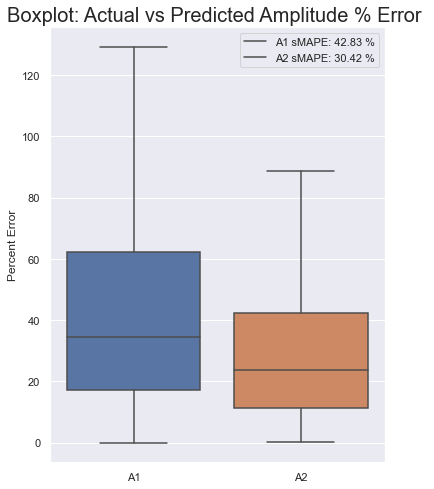

In [99]:
import seaborn as sns

group_labels = ['A1','A2']
sns.set(rc={"figure.figsize":(6, 8)}) #width=3, #height=4
ax = sns.boxplot(data = per_error[['A1','A2']], showfliers = False)
ax.set_ylabel('Percent Error')
ax.set_title('Boxplot: Actual vs Predicted Amplitude % Error ', size = 20)
plt.legend(labels=["A1 sMAPE: " + str(sMAPE(y_actual['A1'],y_pred['A1']).round(decimals = 2)) + " %","A2 sMAPE: " + str(sMAPE(y_actual['A2'],y_pred['A2']).round(decimals = 2)) + " %"])

fig = ax.get_figure()
fig.savefig('Percentage_Error_boxplot.png')  

In [74]:
def absolute_error(y_actual,y_pred):
    return np.abs(y_pred - y_actual)


In [81]:
error_abs = pd.DataFrame()
for column in y_pred.columns:
    error_abs[column] = absolute_error(y_actual[column],y_pred[column])

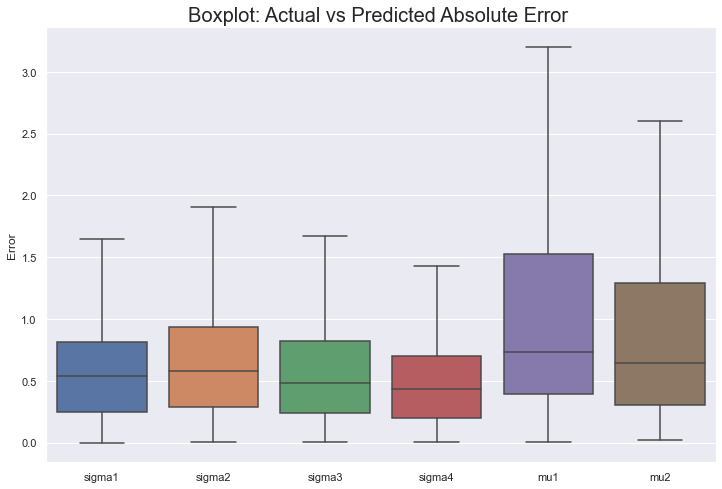

In [98]:
sns.set(rc={"figure.figsize":(12, 8)}) #width=3, #height=4
ax = sns.boxplot(data = error_abs[['sigma1','sigma2','sigma3','sigma4','mu1','mu2']], showfliers = False)
ax.set_ylabel('Error')
ax.set_title('Boxplot: Actual vs Predicted Absolute Error ', size = 20)
ax.legend

fig = ax.get_figure()
fig.savefig('Absolute_Error_boxplot.png')  

# Distribution Plot

C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



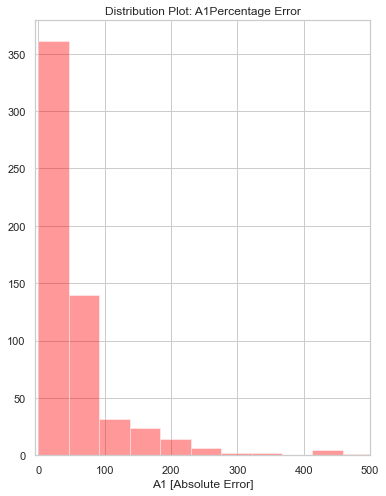

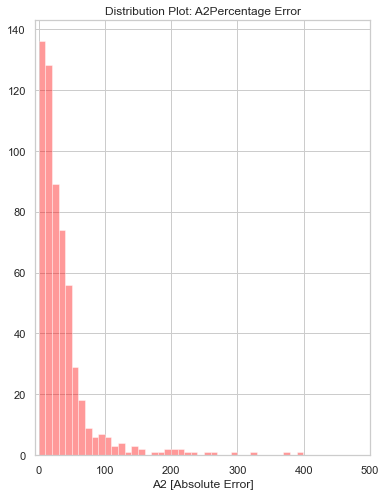

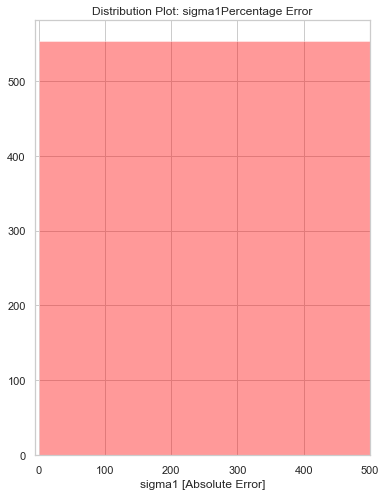

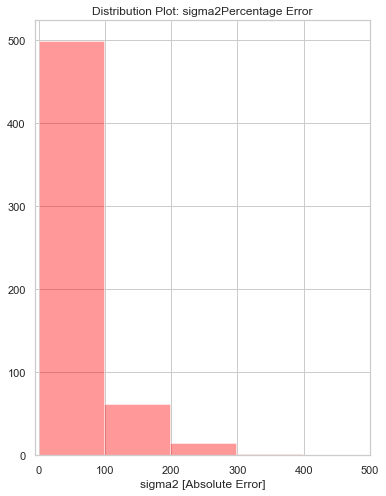

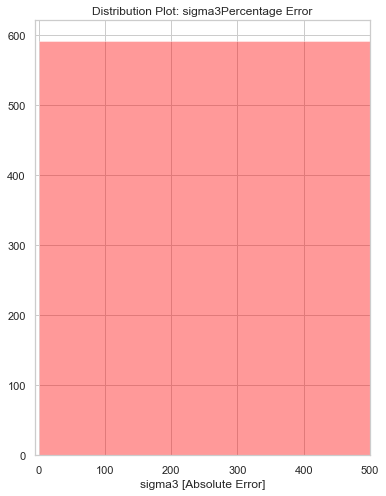

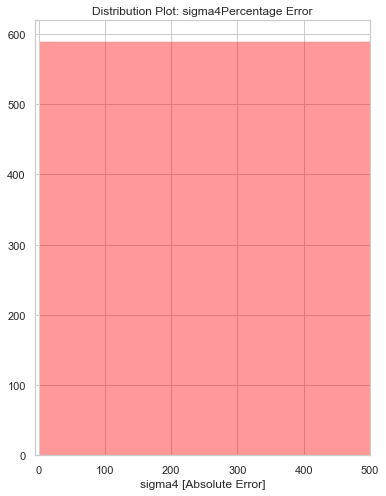

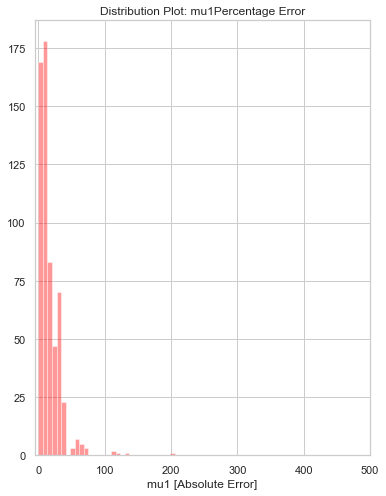

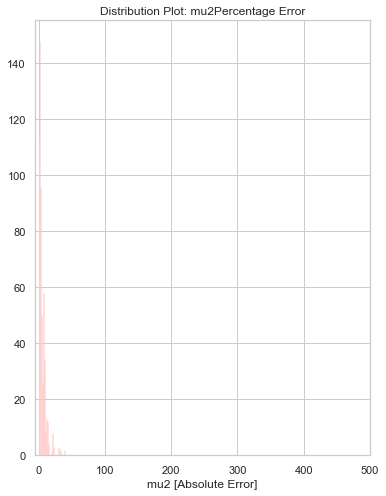

In [120]:
i = 0
for column in per_error.columns:
    # set the background style of the plot
    if i == 1:
        bin = 3000
    else: bin = 30
    plt.figure()
    sns.set_style('whitegrid')
    ax = sns.distplot(per_error[column], kde = False, color ='red', bins = bin)
    ax.set_xlabel(column + ' [Absolute Error]')
    ax.set_title('Distribution Plot: ' + column + 'Percentage Error')
    ax.set_xlim([-5,500])
    fig = ax.get_figure()
    fig.savefig(column + 'Percentage_Error_distribution.png')  
    i = i+1

C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `hi

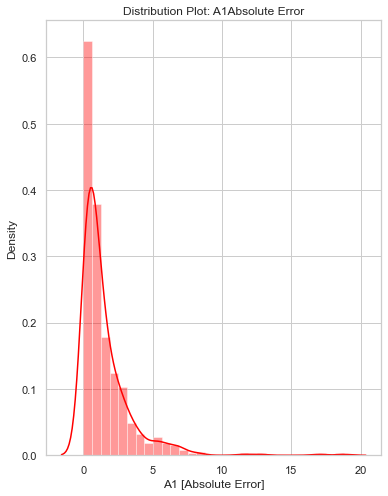

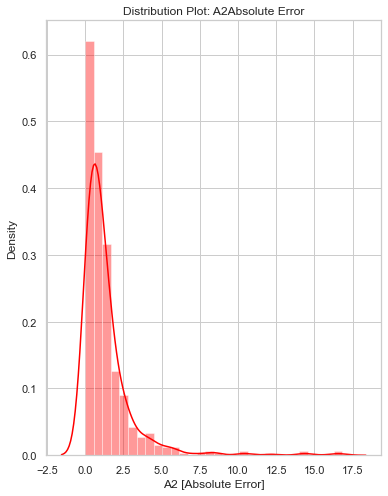

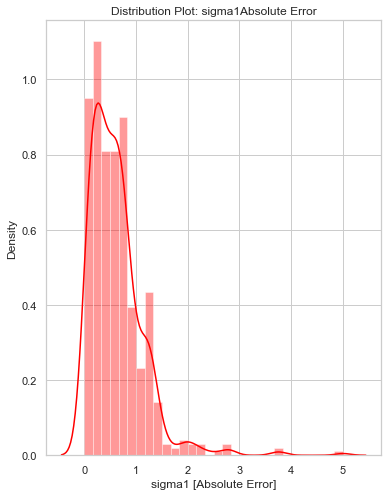

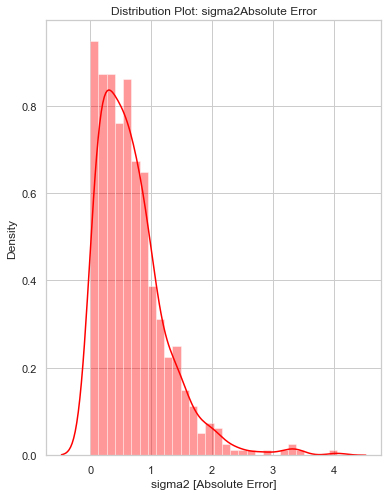

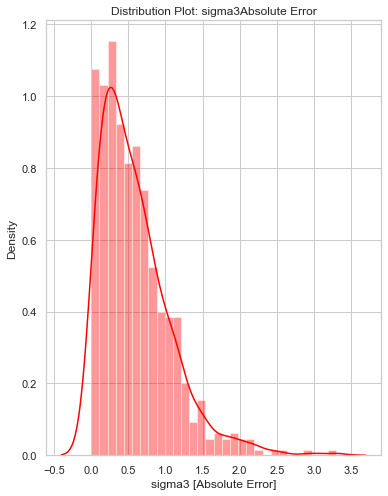

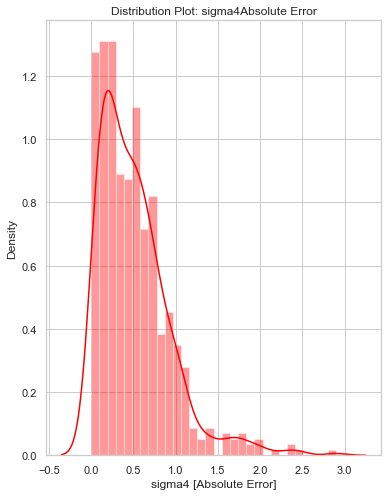

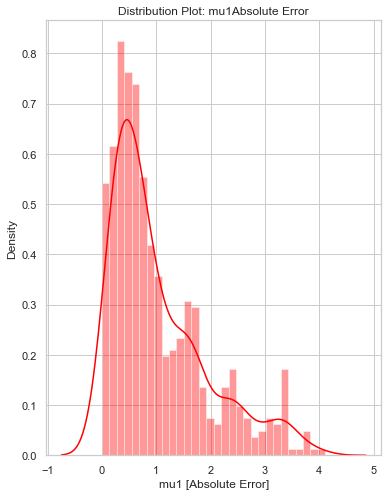

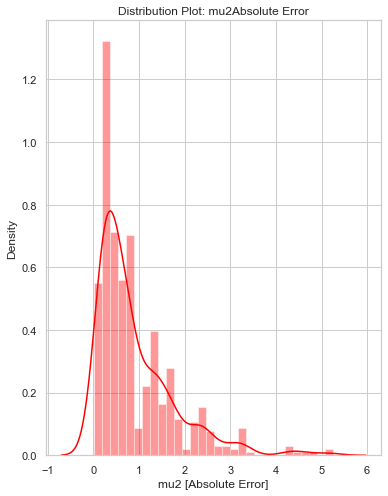

In [109]:

for column in error_abs.columns:
    # set the background style of the plot
    plt.figure()
    sns.set_style('whitegrid')
    ax = sns.distplot(error_abs[column], kde = 'norm', color ='red', bins = 30)
    ax.set_xlabel(column + ' [Absolute Error]')
    ax.set_title('Distribution Plot: ' + column + 'Absolute Error')
    fig = ax.get_figure()
    fig.savefig(column + 'Absolute_Error_distribution.png')  
